In [1]:
import logging, sys
import numpy as np
sys.path.insert(0, "../..")
import scirpy as ir
import scanpy as sc
import pandas as pd
from sklearn import neighbors
import warnings
import csv
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from numba import NumbaPerformanceWarning


## Since we have debugged the code and know that everything works fine, we now supress all kinds of unwanted messages generated
## and only keep the printed or necessary results. This is for the purpose of better readability of the .pdf report generated.

import warnings
warnings.simplefilter('ignore')

logging.disable(sys.maxsize)
## ignore numba performance warnings
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)


Based on the information we get from tracing clonotypes along paired samples, we will zoom in to the pair 295-314, 290_Pri-290_LN2 for a closer look

In [2]:
all_samples = sc.read('/scratch/qc_filtered_combined_samples.h5ad')
selected_genes = all_samples.var_names.str.startswith(("TRAV","TRAJ","TRBV","TRBD","TRBJ","CD8A","CD8B"))
CD8_related_genes = set(all_samples[:,selected_genes].var_names)
kept_cells = all_samples[:,'CD8A'].X>0
for gene in set(CD8_related_genes):
    kept_cells = kept_cells + (all_samples[:,gene].X>0)
all_samples = all_samples[kept_cells,:]

In [3]:
# extract pairs
paired_sample_id = [['295', '314'], ['290_Pri', '290_LN2']]

pairs = []
for pair_id in paired_sample_id:
    pair_cells = all_samples.obs['sample']==pair_id[0]
    pair_cells |= all_samples.obs['sample']==pair_id[1]
    pairs.append(all_samples[pair_cells,])

In [4]:
important_marker_genes = ['CD8A','CD8B','PTPRC','TBX21','CCR5','CXCR3','IL7','SELL','GATA3','CCR6','IL4','GZMB',
                          'PRF1','IL2RB','IL2RA','FOXP3','CD28','IL10','CD44','EOMES','IL17A','IL17B','IL17C','IL10','CD69'
                          'CD27','FAS','KLRG1','CCR7','GZMA','GZMH','GZMK','GZMM','GNYL','ENTPD1','TCF7','ITGAE','CTSW', 
                          'IFNG','CD161','TNFRSF4','TNFRSF18','NKG7','B3GAT1']
important_nonmarker_genes = ['CD4','CD68','CD163','MS4A2','CD14','CD16','XCL2','COL1A2','MMP2','ACTA2','CD79A',
                             'LAMP3','TPSAB1','PECAM1']
exhaustion_markers = ['CXCL13','CTLA4','PDCD1','HAVCR2','TIGIT','BTLA','CD244','CD160','ICOS','LAG3']
proliferation_markers = ['TOP2A','MKI67','TNFRSF9'] 
important_genes = important_marker_genes + important_nonmarker_genes+exhaustion_markers+proliferation_markers
cell_cycle_genes = [x.strip() for x in open('/work/cell_cycle_genes.txt')]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

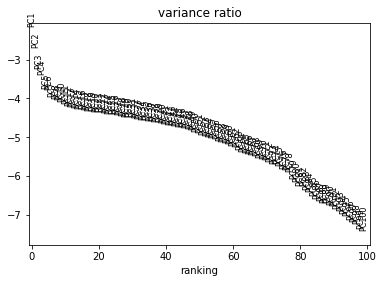

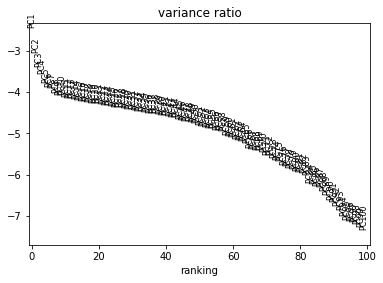

In [5]:
# run PCA and UMAP for each of the pair
for i in range(len(pairs)):
    # compute highly variables genes
    sc.pp.highly_variable_genes(pairs[i], flavor='seurat_v3',n_top_genes=100)
    # dis-select TR genes and HLA genes
    selected = list(pairs[i].var_names.str.startswith(("TRA","TRB","HLA")))
    TCR_genes = set(pairs[i][:,selected].var_names)
    for gene in TCR_genes:
        pairs[i].var['highly_variable'][gene] = False
    # select the important genes
    for gene in important_genes:
        pairs[i].var['highly_variable'][gene] = True
    # limit the genes space to the highly_variable genes + important genes - disselected genes    
    pairs[i].raw = pairs[i]
    pairs[i] = pairs[i][:, pairs[i].var['highly_variable']]
    # regress out cell cycles
    cell_cycle_genes = [x for x in cell_cycle_genes if x in pairs[i].var_names]
    sc.tl.score_genes_cell_cycle(pairs[i], s_genes=s_genes, g2m_genes=g2m_genes)
    sc.pp.regress_out(pairs[i], ['total_counts', 'S_score', 'G2M_score'])
    
    sc.pp.scale(pairs[i], zero_center=False, max_value=10)
    sc.tl.pca(pairs[i], svd_solver='arpack',n_comps=100,use_highly_variable=True)
    sc.pl.pca_variance_ratio(pairs[i], log=True, n_pcs = 100)

In [13]:
umaps = []
for i in range(len(pairs)):
    sc.external.pp.bbknn(pairs[i], batch_key='sample', n_pcs=35) # n_pcs was equal to 10
    umap = sc.tl.umap(pairs[i], n_components=2, min_dist=0.01, spread=0.3, copy=True)
    # Leiden clustering
    sc.tl.leiden(umap)
    # find marker genes
    sc.tl.rank_genes_groups(umap, groupby='leiden', method='wilcoxon')
    umaps.append(umap)

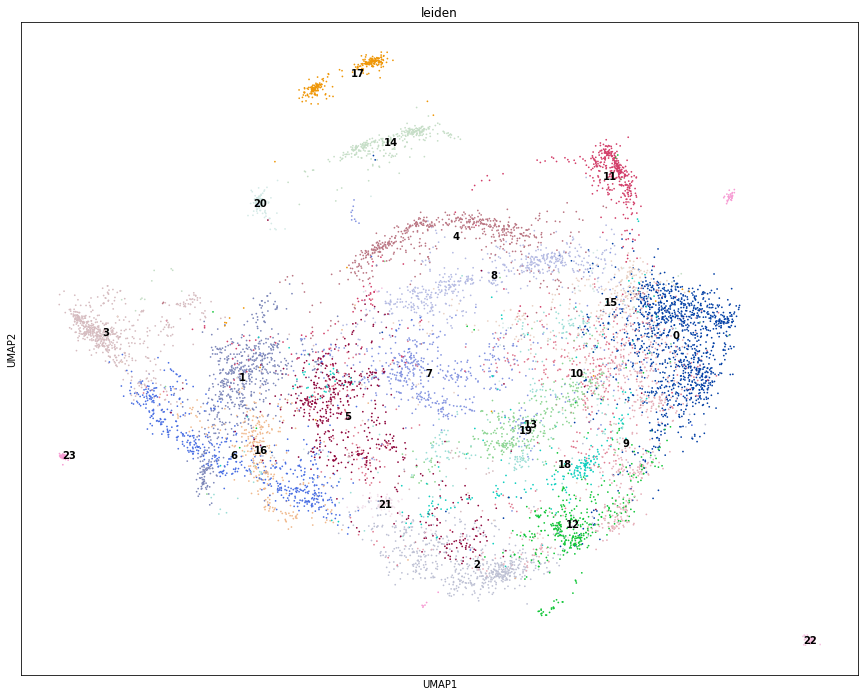

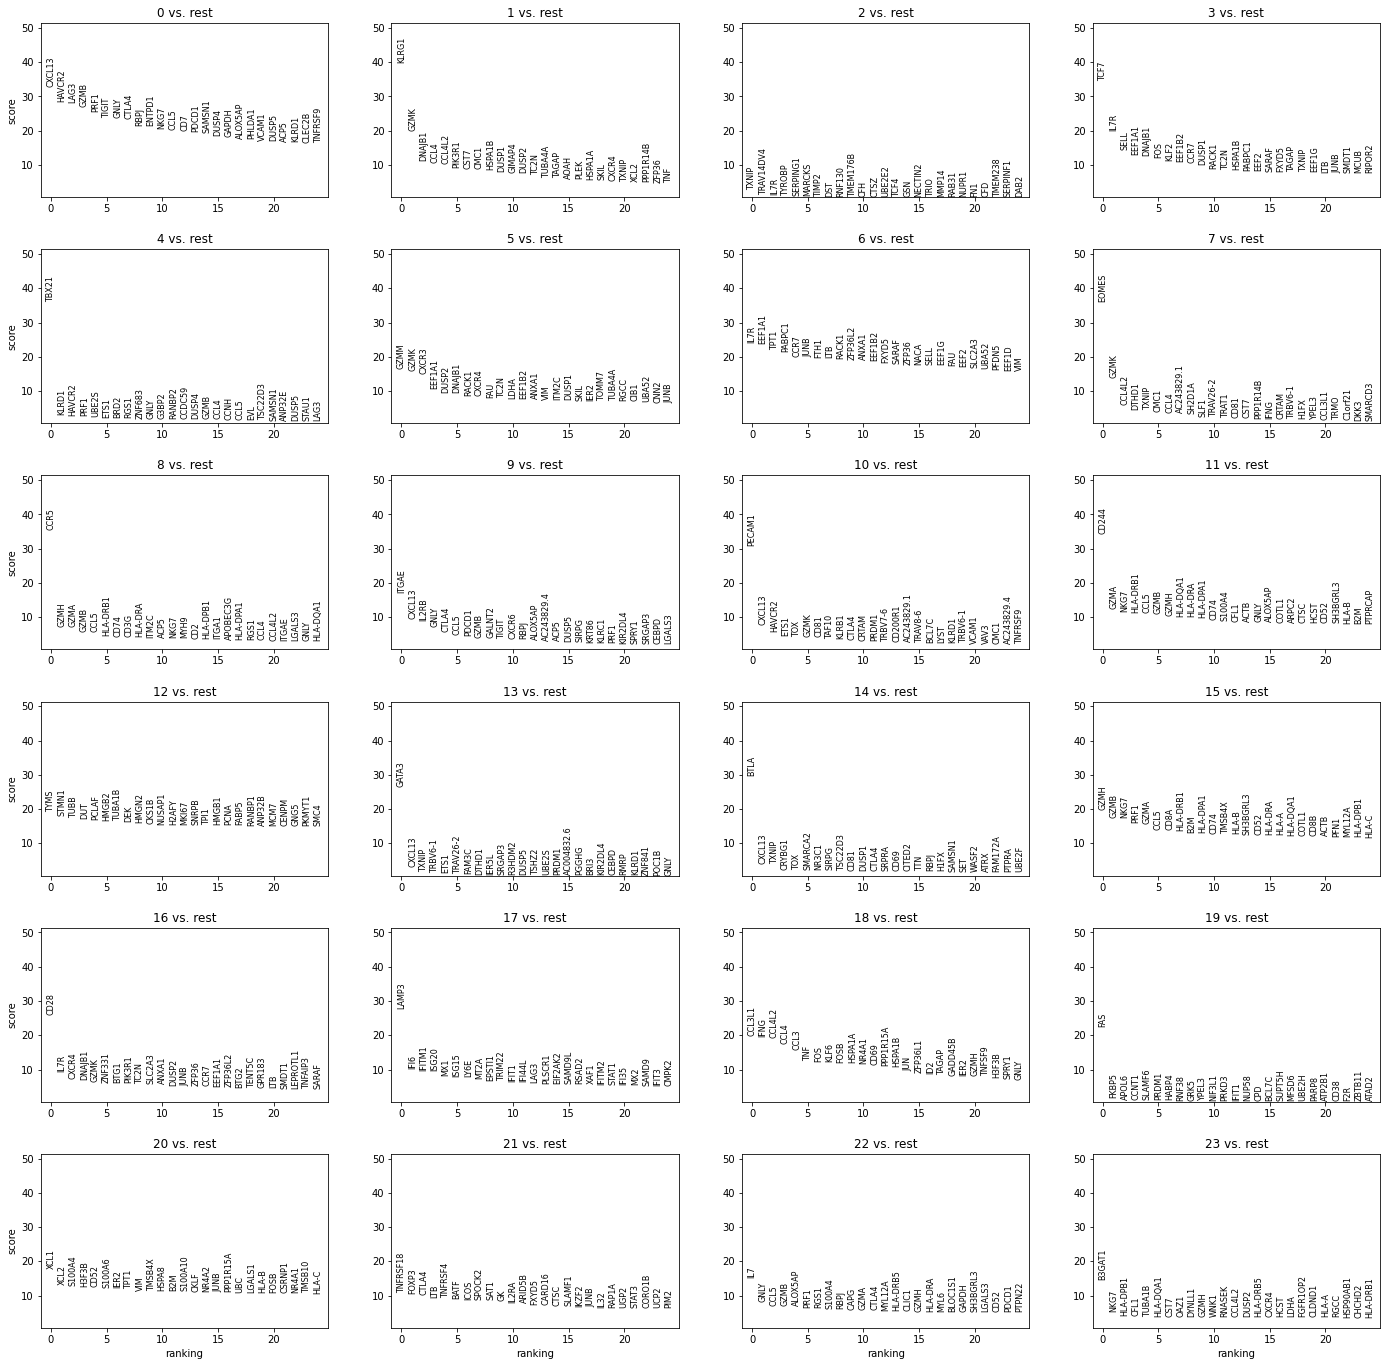

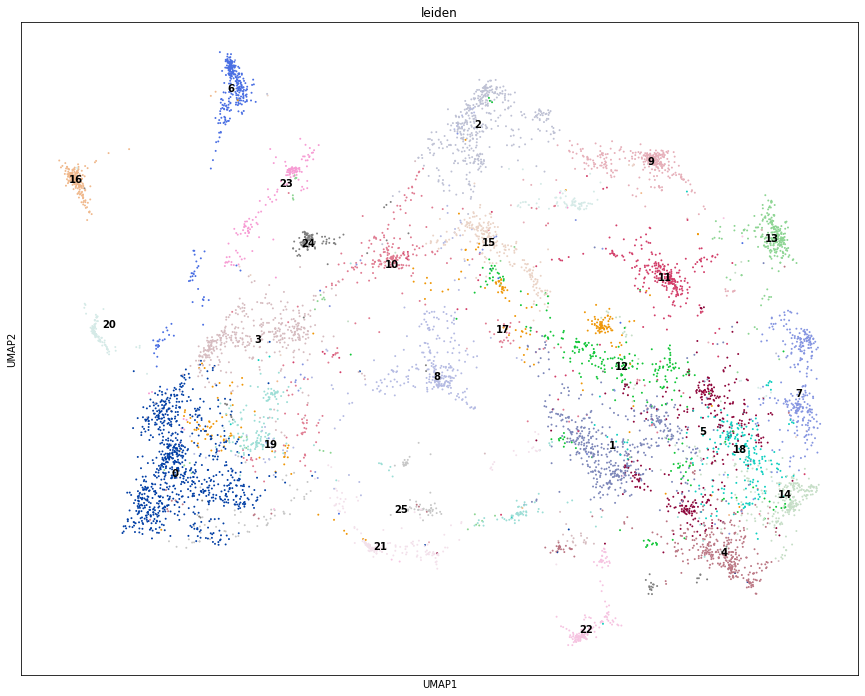

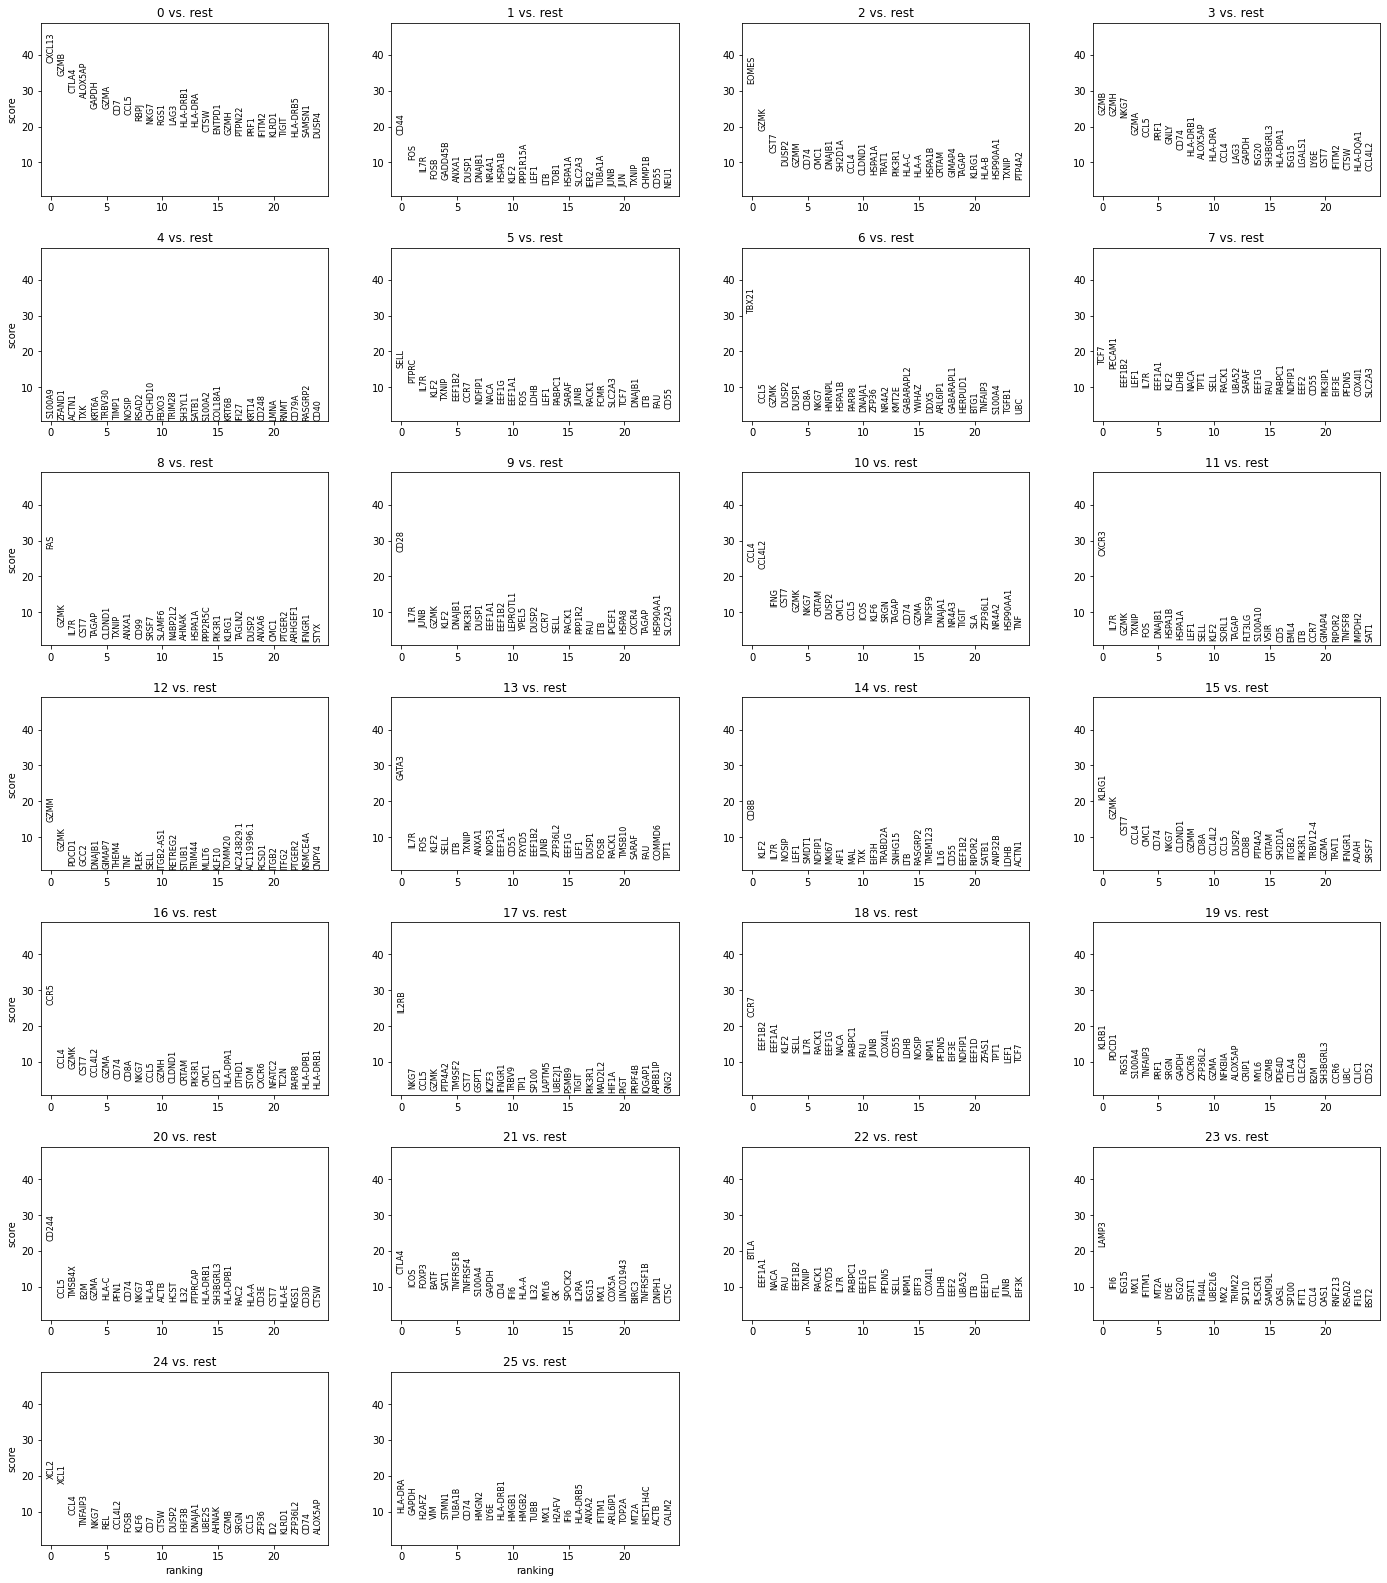

In [14]:
for umap in umaps:
    fig, ax = plt.subplots(figsize=(15,12))
    sc.pl.umap(umap, color='leiden', legend_loc='on data',ax=ax)
    sc.pl.rank_genes_groups(umap,n_genes=25)


In [15]:
for umap in umaps:    
    sample_ids = sorted(list(set(umap.obs['sample'])))
    cluster_marker_gene_file = '/scratch/cluster_genes'+sample_ids[0]+'_and_'+sample_ids[1]+'.csv'
    
    cluster_sizes = []
    for i in range(len(set(umap.obs['leiden']))):
        cluster_sizes.append(sum(umap.obs['leiden']==str(i)))
        with open(cluster_marker_gene_file, 'a') as file:
            file_writer = csv.writer(file)
            file_writer.writerow(['Cluster'+str(i)+':',cluster_sizes[-1]])
            file_writer.writerow(umap.uns['rank_genes_groups']['names'][str(i)][:30])
            file_writer.writerow(umap.uns['rank_genes_groups']['logfoldchanges'][str(i)][:30])